In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pylab
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

warnings.filterwarnings('ignore')

In [2]:
original_datset=pd.read_csv('../Data/train.csv')
df=original_datset.copy()
pd.set_option('display.max_columns', None)

## Glancing at the DataSet

In [3]:
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


#### Null value was only in one feature, imputed it with random values

In [4]:
def imputer(df, feature):
    df[feature] = df[feature]
    random_sample = df[feature].dropna().sample(df[feature].isnull().sum(), random_state=69)
    random_sample.index = df[df[feature].isnull()].index
    df.loc[df[feature].isnull(), feature] = random_sample


imputer(df,'Vertical_Distance_To_Hydrology')

## Feature Engineering

### Important Features -

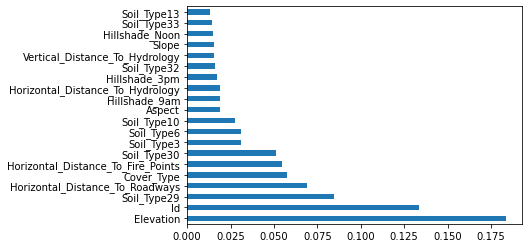

In [5]:
X = df.drop(labels=['Wilderness_Area1',
            'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'], axis=1)
y = df[['Wilderness_Area1',
        'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']]


def ETC(number):
    model = ExtraTreesClassifier()
    model.fit(X, y)
    ranked_features = pd.Series(model.feature_importances_, index=X.columns)
    ranked_features.nlargest(number).plot(kind='barh')

    plt.show()

ETC(20)


### Checking Gausian Distribution by using Q-Q Plot on Features except Soil_Type, Wilderness_Area and Cover_Type


Id


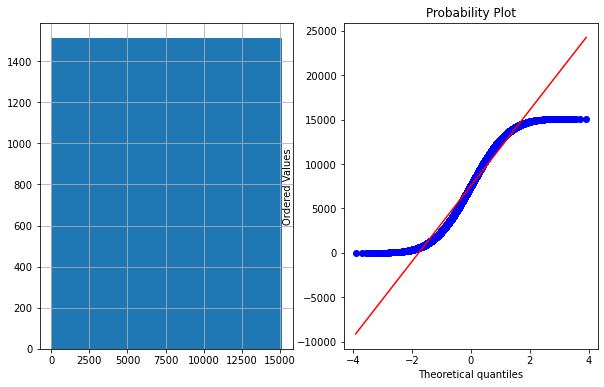

Elevation


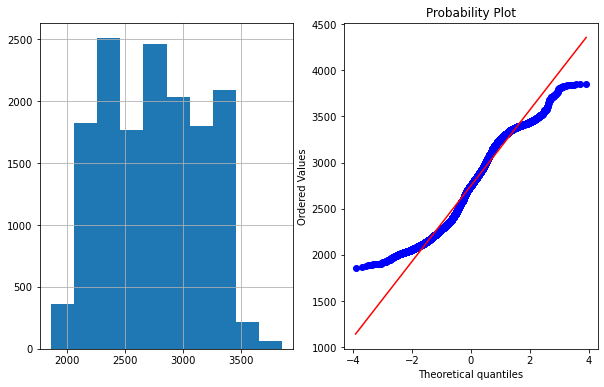

Aspect


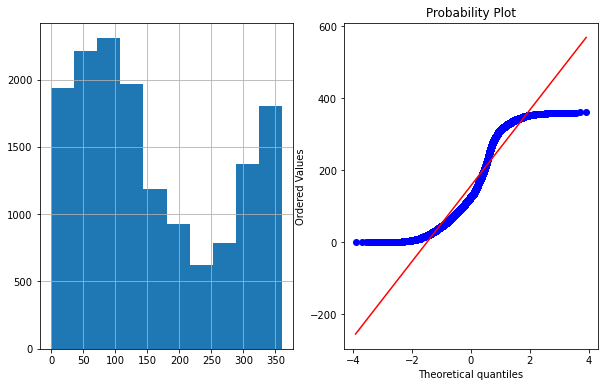

Slope


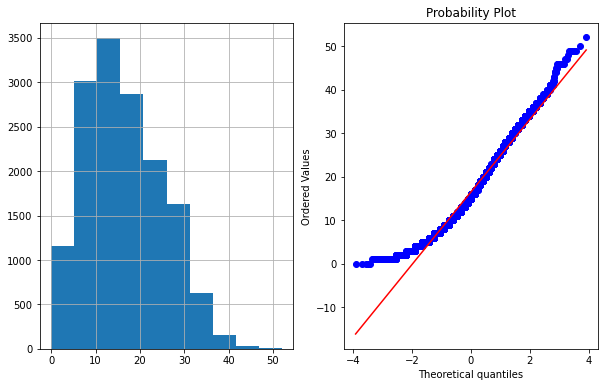

Horizontal_Distance_To_Hydrology


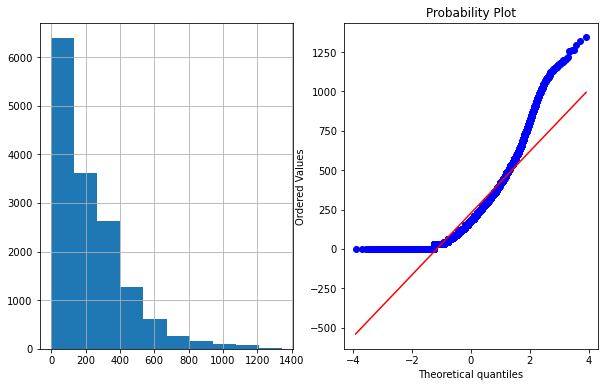

Vertical_Distance_To_Hydrology


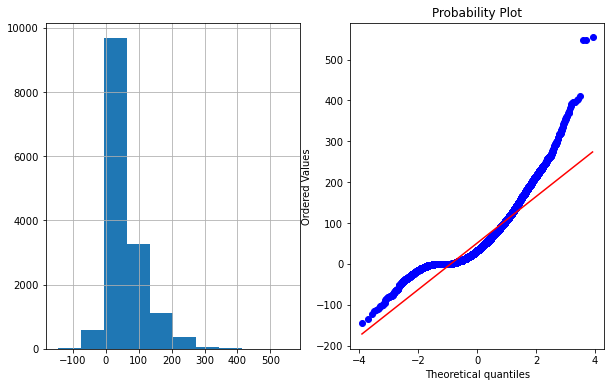

Horizontal_Distance_To_Roadways


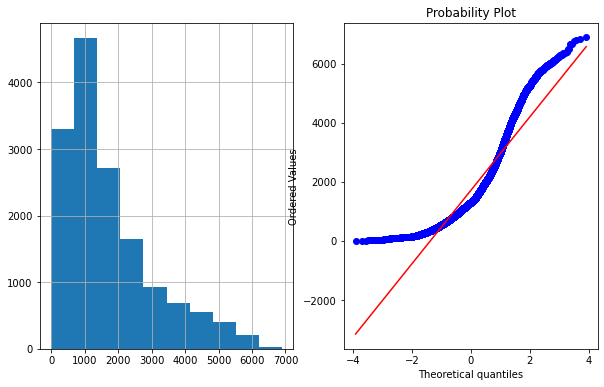

Hillshade_9am


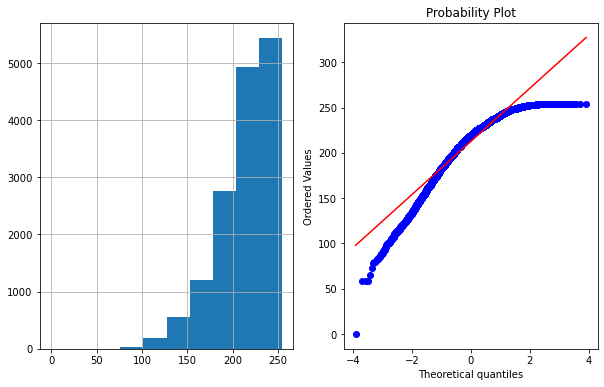

Hillshade_Noon


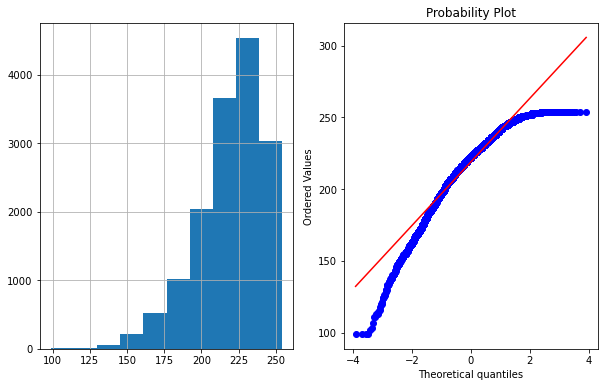

Hillshade_3pm


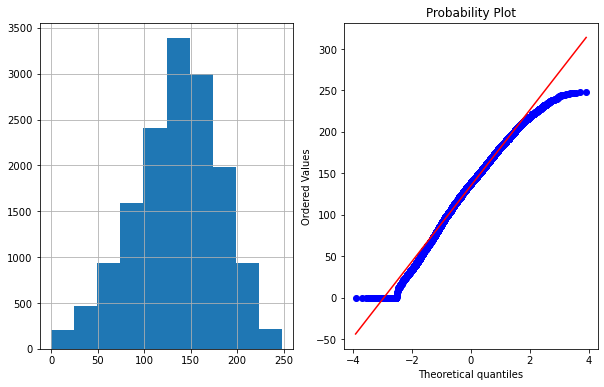

Horizontal_Distance_To_Fire_Points


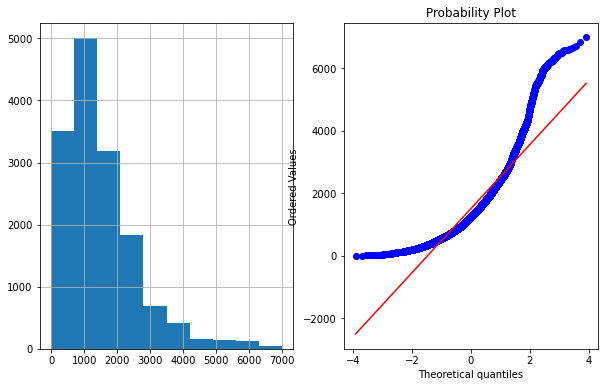

In [6]:

temp = df.drop(df.iloc[:, 11:], axis=1)
temp.head()

def QQ_plot(df, feature):
    # This is for the left graph
    print(feature)
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)

    # This is for the right graph if it's majority of the data is following in the red line, then it is gausian transformation otherwise not
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stat.probplot(df[feature], dist='norm', plot=pylab)
    plt.show()

for i in temp:
    QQ_plot(temp,i)


### Performing Exponential Transformation to convert the Features  into Gausian Distribution

Id


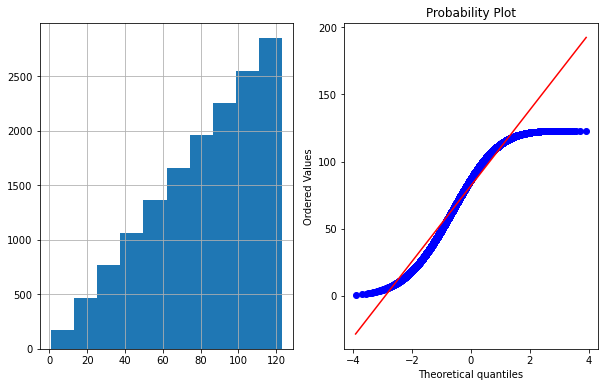

Elevation


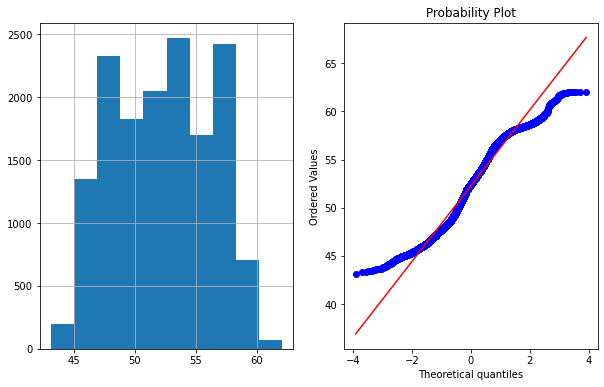

Aspect


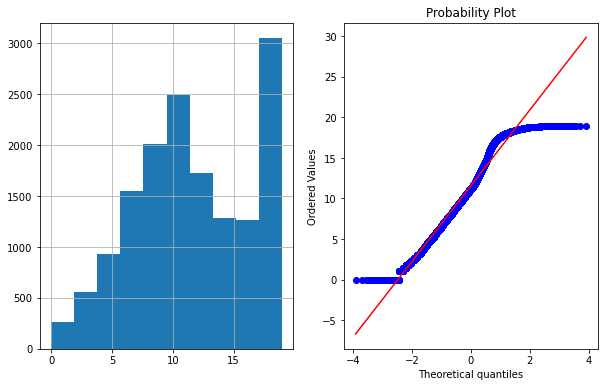

Slope


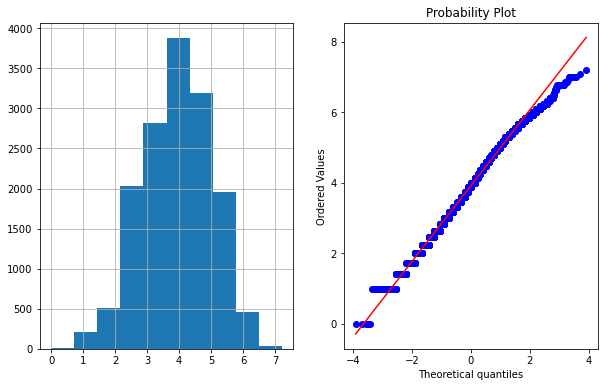

Horizontal_Distance_To_Hydrology


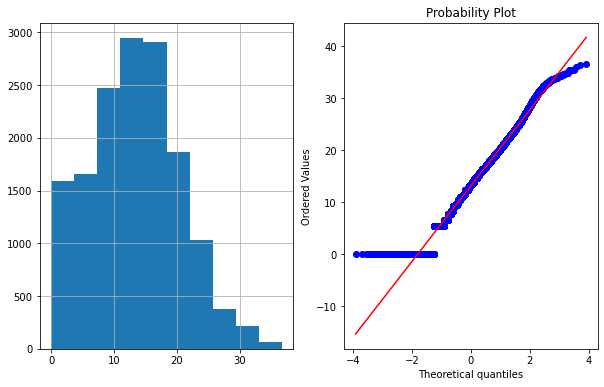

Vertical_Distance_To_Hydrology


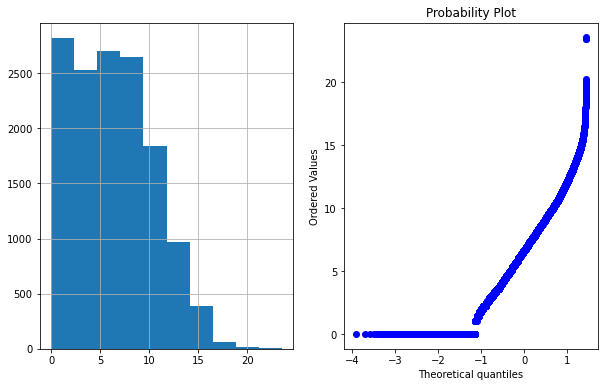

Horizontal_Distance_To_Roadways


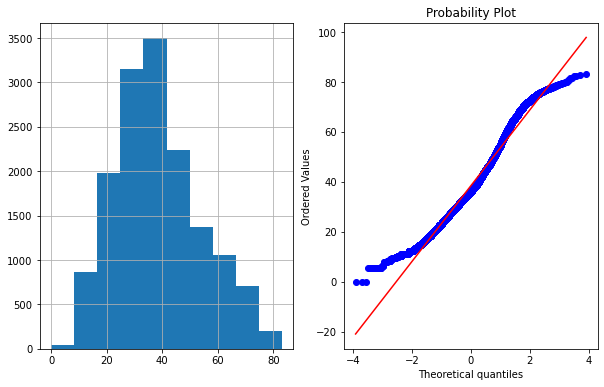

Hillshade_9am


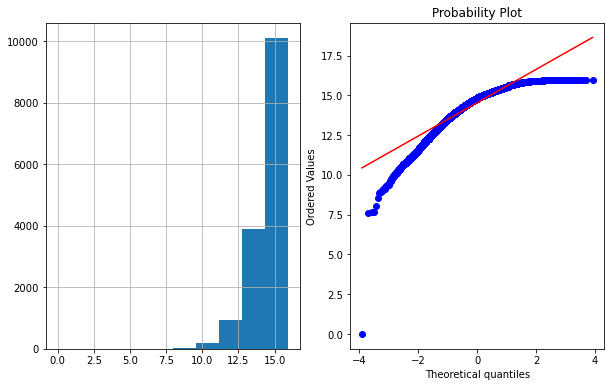

Hillshade_Noon


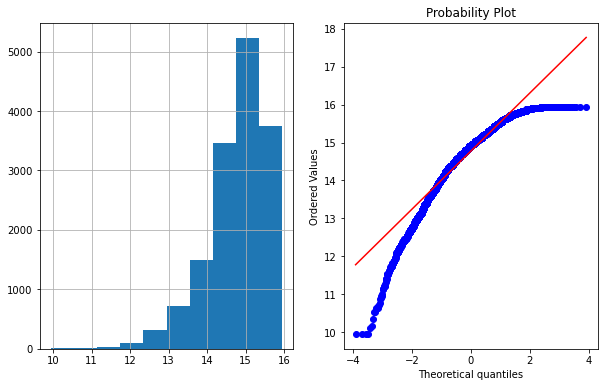

Hillshade_3pm


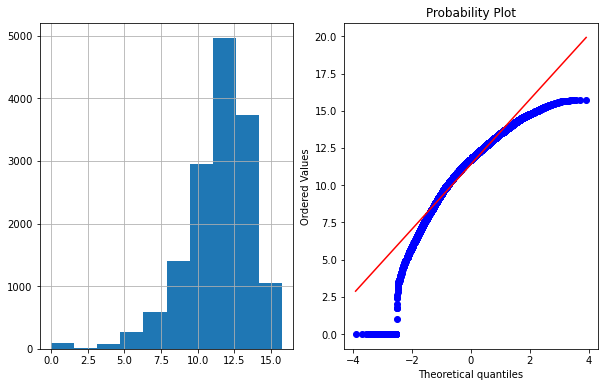

Horizontal_Distance_To_Fire_Points


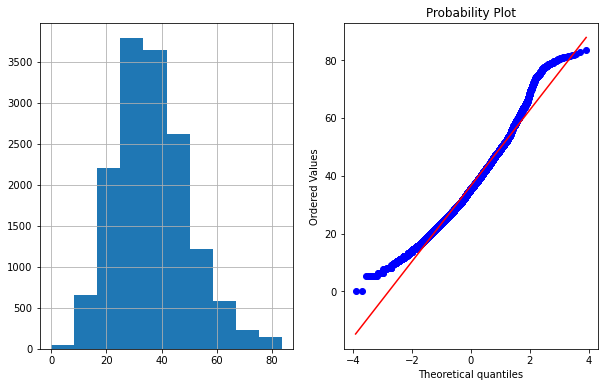

In [7]:
# Not transforming  tranformation on these as they are already in Gausian Distribution
temp.drop(labels=['Hillshade_3pm', 'Vertical_Distance_To_Hydrology'], axis=1)

for i in temp:
    temp[i] = temp[i]**(1/2)

for i in temp:
    QQ_plot(temp, i)


### Finding and Dropping the Highly Correlated Features

In [8]:
def correlation_2(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # we are interested in absolute coeff value
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)

    return col_corr

correlation_2(df, 0.7)

df.drop(labels=['Hillshade_3pm'], axis=1, inplace=True)


#### We do not need to fix the outlier in the dataset as  most of the Algorithms of Classification can handle the Outliers Efficiently

## Model Creation

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(labels=['Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'], axis=1)
y = df[['Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']]

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.33, random_state=69)

X_train.shape, X_test.shape

((10130, 51), (4990, 51))

### RandomForestClassifier

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
prediction=rfc.predict(X_test)

print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

0.9767535070140281
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1216
           1       0.99      0.75      0.85       174
           2       0.98      0.99      0.99      2077
           3       0.99      1.00      1.00      1523

   micro avg       0.99      0.98      0.98      4990
   macro avg       0.99      0.92      0.95      4990
weighted avg       0.99      0.98      0.98      4990
 samples avg       0.98      0.98      0.98      4990



### DecisionTreeClassifier

In [11]:
from sklearn.tree import DecisionTreeClassifier

dtc=DecisionTreeClassifier()
dtc.fit(X_train, y_train)
prediction=dtc.predict(X_test)

print(accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))


0.9771543086172345
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1216
           1       0.87      0.88      0.87       174
           2       0.97      0.97      0.97      2077
           3       0.99      0.99      0.99      1523

   micro avg       0.98      0.98      0.98      4990
   macro avg       0.95      0.96      0.95      4990
weighted avg       0.98      0.98      0.98      4990
 samples avg       0.98      0.98      0.98      4990



### KNeighborsClassifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier

knc=KNeighborsClassifier()
knc.fit(X_train, y_train)
prediction=knc.predict(X_test)

print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

0.9803607214428858
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1216
           1       0.97      0.91      0.94       174
           2       0.98      0.98      0.98      2077
           3       0.99      1.00      1.00      1523

   micro avg       0.98      0.98      0.98      4990
   macro avg       0.98      0.96      0.97      4990
weighted avg       0.98      0.98      0.98      4990
 samples avg       0.98      0.98      0.98      4990



### KNeighborsClassifier is Giving the best Accuracy and will be using that to build the model

In [13]:
import joblib

joblib.dump(knc,'model.pkl')

['model.pkl']